In [1]:
%load_ext autoreload
%autoreload 2
from utils.utils import *
from utils.utils_train import *
from utils.utils_imports import *

In [2]:
# Load SBERT Embeddings
queries, query_embeddings, product_embeddings = load_raw_queries()

# load ids_toys from disk
with open('output/ids_toys.pkl', 'rb') as file:
    ids_toys = pickle.load(file)
    print(len(ids_toys))
    ids_present = [_id for _id in ids_toys if _id in query_embeddings]

# Assemble qb & xb input embeddings
qb = torch.stack([torch.tensor(query_embeddings[_id]) for _id in ids_present])
xb = torch.tensor(np.array([product_embeddings[_id] for _id in ids_present]))

# Split Dataset into Train and Test
(qb_train, qb_test), (xb_train, xb_test), (idx_train, idx_test) = shuffle_and_split(qb, xb, seed=12)
print('qb_train.shape:', qb_train.shape)
print('qb_test.shape:', qb_test.shape)


loaded (queries, query_embeddings, product_embeddings) from  output/raw_queries.pkl
84373
qb_train.shape: torch.Size([20560, 768])
qb_test.shape: torch.Size([5140, 768])


In [8]:
# Two-Tower Pytorch Model
d = hidden_dim = qb_train.shape[-1]
# list_recall3 = []
# list_test_epochs = []

# Initialize the network
model = TwoTowerNetwork(d, hidden_dim) 
[print(f"{key:16s}: {val}") for key, val in config.items()]
print()
print(model)
model.size()

dropout         : 0.1
learning_rate   : 0.001
label_smoothing : 0.3
batch_size      : 1024
eval_iter       : 1

TwoTowerNetwork(
  (qb_tower): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=768, out_features=768, bias=True)
    (4): Dropout(p=0.1, inplace=False)
  )
  (xb_tower): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=768, out_features=768, bias=True)
    (4): Dropout(p=0.1, inplace=False)
  )
)
num_params:2.36 million 


recall@3 = 0.024                    
recall@3 = 0.031                    
recall@3 = 0.038                    
recall@3 = 0.049                    
recall@3 = 0.076                    
recall@3 = 0.092                    
recall@3 = 0.206                    
recall@3 = 0.289                    
recall@3 = 0.304                    
recall@3 = 0.264                    
recall@3 = 0.386                    
recall@3 = 0.301                    
recall@3 = 0.429                    
recall@3 = 0.511                    
recall@3 = 0.557                    
recall@3 = 0.598                    
recall@3 = 0.602                    
recall@3 = 0.603                    
recall@3 = 0.567                    
recall@3 = 0.625                    
recall@3 = 0.663                    
recall@3 = 0.661                    
recall@3 = 0.685                    
recall@3 = 0.684                    
recall@3 = 0.696                    


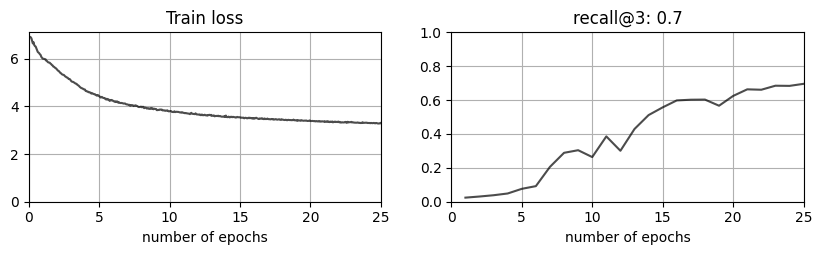

recall@3 = 0.694                    
recall@3 = 0.694                    
recall@3 = 0.716                    
recall@3 = 0.700                    
recall@3 = 0.687                    
recall@3 = 0.707                    
recall@3 = 0.718                    
recall@3 = 0.725                    
recall@3 = 0.712                    
recall@3 = 0.726                    
recall@3 = 0.748                    
recall@3 = 0.748                    
recall@3 = 0.741                    
recall@3 = 0.734                    
recall@3 = 0.741                    
recall@3 = 0.745                    
recall@3 = 0.741                    
recall@3 = 0.740                    
recall@3 = 0.735                    
recall@3 = 0.740                    
recall@3 = 0.752                    
recall@3 = 0.742                    
recall@3 = 0.762                    
recall@3 = 0.750                    
recall@3 = 0.755                    


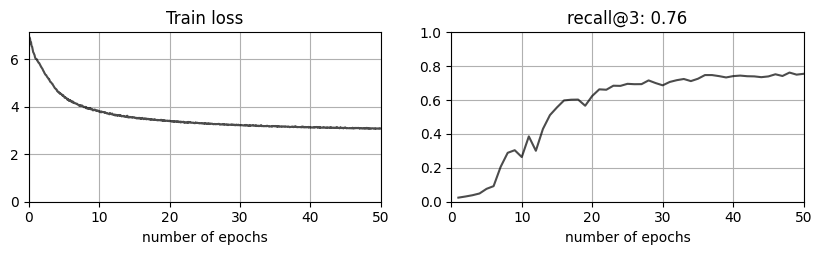

recall@3 = 0.759                    
recall@3 = 0.748                    
recall@3 = 0.745                    
recall@3 = 0.752                    
recall@3 = 0.761                    
recall@3 = 0.756                    
recall@3 = 0.739                    
recall@3 = 0.762                    
recall@3 = 0.755                    
recall@3 = 0.742                    
recall@3 = 0.747                    
recall@3 = 0.765                    
recall@3 = 0.744                    
recall@3 = 0.747                    
recall@3 = 0.761                    
recall@3 = 0.739                    
recall@3 = 0.748                    
recall@3 = 0.754                    
recall@3 = 0.751                    
recall@3 = 0.736                    
recall@3 = 0.753                    
recall@3 = 0.752                    
recall@3 = 0.740                    
recall@3 = 0.756                    
recall@3 = 0.749                    


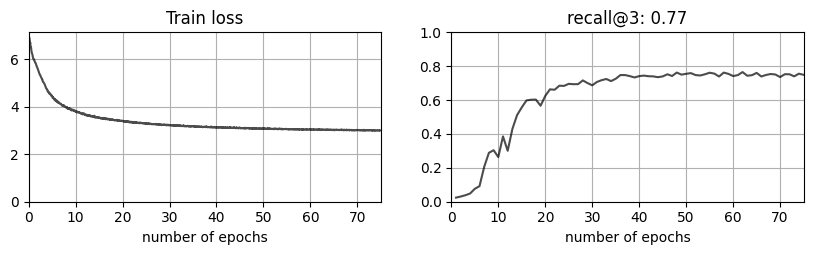

recall@3 = 0.759                    
recall@3 = 0.748                    
recall@3 = 0.745                    
recall@3 = 0.748                    
recall@3 = 0.766                    
recall@3 = 0.765                    
recall@3 = 0.750                    
recall@3 = 0.756                    
recall@3 = 0.757                    
recall@3 = 0.760                    
recall@3 = 0.751                    
recall@3 = 0.758                    
recall@3 = 0.769                    
recall@3 = 0.743                    
recall@3 = 0.764                    
recall@3 = 0.765                    
recall@3 = 0.749                    
recall@3 = 0.759                    
recall@3 = 0.756                    
recall@3 = 0.752                    
recall@3 = 0.747                    
recall@3 = 0.748                    
recall@3 = 0.757                    
recall@3 = 0.761                    
recall@3 = 0.747                    


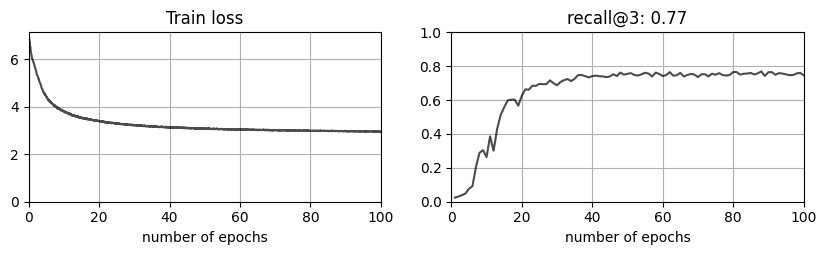

recall@3 = 0.749                    
recall@3 = 0.742                    
recall@3 = 0.766                    
recall@3 = 0.755                    
recall@3 = 0.754                    
recall@3 = 0.758                    
recall@3 = 0.746                    
recall@3 = 0.745                    
recall@3 = 0.750                    
recall@3 = 0.730                    
recall@3 = 0.735                    
recall@3 = 0.768                    
recall@3 = 0.748                    
recall@3 = 0.759                    
recall@3 = 0.758                    
recall@3 = 0.739                    
recall@3 = 0.759                    
recall@3 = 0.747                    
recall@3 = 0.721                    
recall@3 = 0.738                    
recall@3 = 0.746                    
recall@3 = 0.746                    
recall@3 = 0.738                    
recall@3 = 0.764                    
recall@3 = 0.751                    


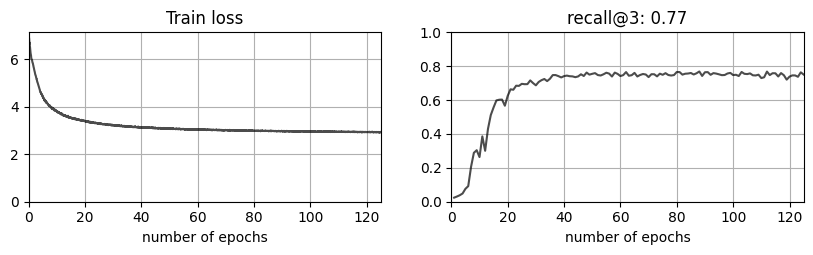

recall@3 = 0.751                    
recall@3 = 0.754                    
recall@3 = 0.752                    
recall@3 = 0.739                    
recall@3 = 0.739                    
recall@3 = 0.756                    
recall@3 = 0.748                    
recall@3 = 0.765                    
recall@3 = 0.747                    
recall@3 = 0.761                    
recall@3 = 0.744                    
recall@3 = 0.750                    
recall@3 = 0.751                    
recall@3 = 0.753                    
recall@3 = 0.763                    
recall@3 = 0.747                    
recall@3 = 0.756                    
recall@3 = 0.743                    
recall@3 = 0.753                    
recall@3 = 0.735                    
recall@3 = 0.754                    
recall@3 = 0.739                    
recall@3 = 0.724                    
recall@3 = 0.739                    
recall@3 = 0.758                    


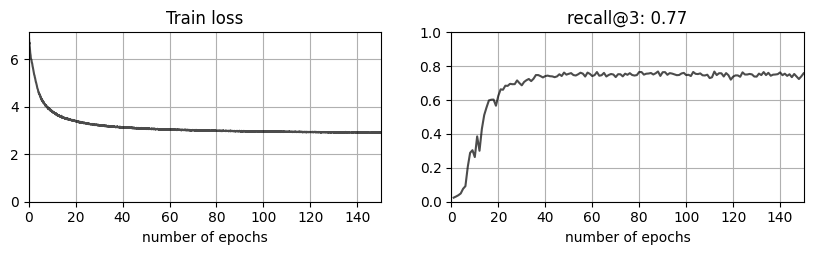

recall@3 = 0.739                    
recall@3 = 0.746                    
recall@3 = 0.750                    
recall@3 = 0.740                    
recall@3 = 0.738                    
recall@3 = 0.734                    
recall@3 = 0.728                    
recall@3 = 0.740                    
recall@3 = 0.735                    
recall@3 = 0.737                    
recall@3 = 0.729                    
recall@3 = 0.745                    
recall@3 = 0.738                    
recall@3 = 0.723                    
recall@3 = 0.746                    
recall@3 = 0.735                    
recall@3 = 0.731                    
recall@3 = 0.734                    
recall@3 = 0.735                    
recall@3 = 0.718                    
recall@3 = 0.735                    
recall@3 = 0.723                    
recall@3 = 0.742                    
recall@3 = 0.725                    
recall@3 = 0.725                    


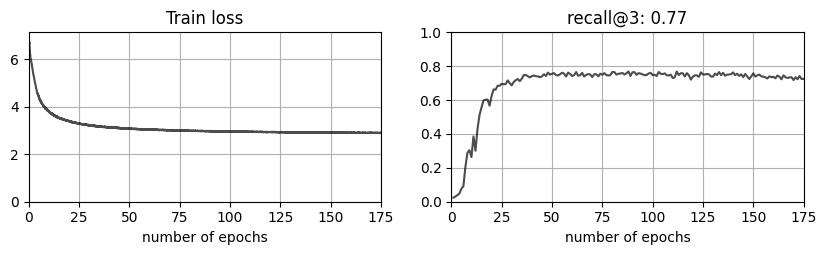

recall@3 = 0.734                    
recall@3 = 0.741                    
recall@3 = 0.723                    
recall@3 = 0.727                    
recall@3 = 0.731                    
recall@3 = 0.727                    
recall@3 = 0.733                    
recall@3 = 0.719                    
recall@3 = 0.735                    
recall@3 = 0.711                    
recall@3 = 0.706                    
recall@3 = 0.734                    
recall@3 = 0.733                    
recall@3 = 0.732                    
recall@3 = 0.727                    
recall@3 = 0.734                    
recall@3 = 0.730                    
recall@3 = 0.731                    
recall@3 = 0.732                    
recall@3 = 0.732                    
recall@3 = 0.733                    
recall@3 = 0.726                    
recall@3 = 0.725                    
recall@3 = 0.717                    
recall@3 = 0.746                    


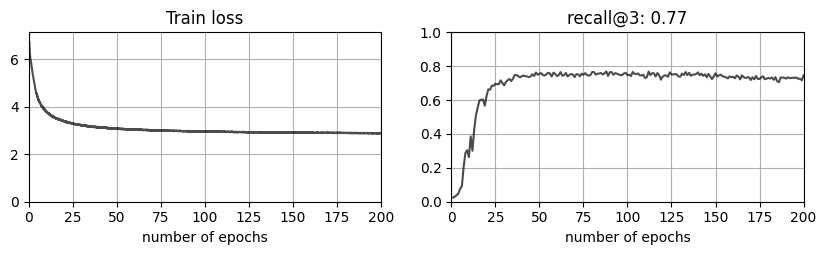

recall@3 = 0.724                    
recall@3 = 0.727                    
recall@3 = 0.712                    


KeyboardInterrupt: 

In [4]:
## TRAIN
# Hyperparameters
num_epochs = 1

for i in range(3000):

    # reshuffle the trainset at beginning of each epoch
    (qb_train, _), (xb_train, _), (_) = shuffle_and_split(qb_train, xb_train, split=1)

    # train for 1 epoch
    model.fit(qb_train, xb_train, num_epochs)

    # write output embeddings to use for eval
    write_output_embeddings(model, qb_test, xb_test) 

    # run eval
    os.system('cd utils && python3 utils_infer.py')

    # read recall@3 metric written to json file
    with open('output/recall3.json', 'r') as file:
        recall3 = json.load(file)['recall3']

    # monitor metrics to plot recall.
    list_test_epochs.append(model.epochs[-1])
    list_recall3.append(recall3) 

    if (i+1) % 25 == 0:
        model.plot(qb_train, list_test_epochs, list_recall3) 

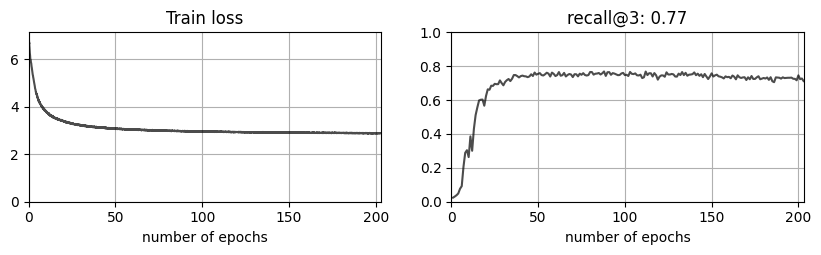

In [5]:
model.plot(qb_train, list_test_epochs, list_recall3)


In [ ]:
# TODO:
# 1. figure out how to incorporate a learning_rate scheduler
# 2. print the top 3 results for hits. 
# 3. naive baseline on SBERT embeddings recall@3 = 0.745

In [15]:
write_output_embeddings(model, qb_test, xb_test) 

In [16]:
os.system('cd utils && python3 utils_infer.py')


recall@3 = 0.745                    


0

### The End

In [ ]:
# Load queries, ids_toys, ids_present
with open('output/raw_queries.pkl', 'rb') as file:
    queries, _, _ = pickle.load(file)

with open('output/ids_toys.pkl', 'rb') as file:
    ids_toys = pickle.load(file)
    ids_present = [_id for _id in ids_toys if _id in query_embeddings]


In [5]:
top_ids = [ids_present[idx_test[i]] for i in I[0]]
names = [info[_id]['name'] for _id in top_ids]
details = [info[_id]['details'] for _id in top_ids]
description = [info[_id]['description'] for _id in top_ids]
queries[ids_present[idx_test[0]]]

"I need to buy a Super-duper Tutu/Cape/Mask set in size 4-6 for my 4-6-year-old. It's a 3-piece set perfect for little Superheroines and Rock Stars!"